# Visión por Computador - Práctica 1 - Filtrado de Imágenes

#### 12 puntos   |   Fecha de entrega: 03 de Noviembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>Eduardo Rodríguez Cao</mark>



---

## Normas de entrega

1. Para este trabajo, al igual que para los demás, se debe presentar código, resultados, discusión de los mismos, y presentación y análisis del trabajo realizado, todo integrado en el propio Google Colab Notebook (es decir, no se entrega ninguna memoria separada en `.pdf` ni ningún código `.py`). Se recuerda que código y resultados sin informe explicativo no puntúa.

2. En relación con el punto anterior, solo se acepta la entrega de ficheros `.ipynb` (no resulta válido entregar un fichero `.py`).

3. El diseño de celdas del documento debe ser respetado.

4. Solo se entregará el fichero `.ipynb` (incorporando código, resultados, y explicación del trabajo realizado y los resultados obtenidos) y no se enviarán las imágenes empleadas.

5. El path para la lectura de imágenes, o cualquier otro fichero de entrada, debe ser siempre “/content/drive/My Drive/images/nombre_fichero”

6. El código deberá  presentarse adecudamente comentado y con los resultados obtenidos en cada apartado, junto con la presentación del trabajo realizado y la discusión y análisis de los resultados obtenidos. Es importante reiterar que la entrega de código sin informe explicativo o valoraciones no puntúa. Por otro lado, el código debe ir comentado en comentarios en celdas de código, mientras que el análisis y discusión, tanto del trabajo realizado como de los resultados obtenidos, debe ir en celdas de texto.

Este trabajo de implementación tiene como objetivo principal **familiarizarse con la implementación y uso de filtros de convolución, así como del cálculo de las derivadas de una imagen y sus posibles aplicaciones**.








---



## Funciones de apoyo y conexión con Google Drive

In [1]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# We import the modules to use
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
# change directory
%cd '/content/drive/My Drive'
#  the current directory
%pwd

# This allows to display images  and to save  them in cells
%matplotlib inline
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/My Drive/images', route)

/content/drive/My Drive


Las funciones que se incluyen a continuación, se proporcionan como ayuda/apoyo para el estudiante. **En caso de que el alumnado prefiera utilizar otras funciones para lectura, normalización y visualización de imágenes, tiene total libertad para hacerlo, pero sí debe justificar y explicar razonadamente el motivo de dicho cambio y describir las modificaciones realizadas.**

Recuérdese que todas las imágenes a emplear durante las prácticas de todo el curso se pueden encontrar en el enlace de Google Drive indicado en PRADO: https://pradogrado2425.ugr.es/mod/url/view.php?id=91457 En concreto, https://drive.google.com/drive/folders/1UtvY8q6w1Cz9a9T9zxIqSweoRLgNwoW-

In [3]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [4]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [5]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im es tribanda
    plt.imshow(im, cmap='jet')
  else:
    # im es monobanda
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([]) # eliminamos numeración
  plt.show()

In [6]:
'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Manzanas',factor=1)

IMPORTANT NOTE: it is important to notice that this function stacks all images
and later call displayIm(). This implies that the normalization (rangeDisplay01()) is done
at the very end of the process. As a consequence, if the stacked images have different
range values they can be displayed in a "weird" way (with black regions (pixel value = 0)
looking grey). In case the visualization seems to be a problem, a possible solution
would be to create vim using vim.append(rangeDisplay01(...)). In this way, all images
would be on the same range of values (negative values around 0 (black),
0 values around 0.5 (grey), and positive values closer to 1 (white))

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

# **Ejercicio 1: discretización de máscaras y filtrado Gaussiano** (6 puntos)

En este ejercicio aprenderemos a discretizar máscaras de convolución y a aplicarlas sobre imágenes empleando funciones de OpenCV. También buscamos hacerlo de un modo eficiente, y es por ello que, en toda la práctica, se exige el uso de convoluciones 1D (separables).





## A) (1.5 puntos)

En este apartado se deben realizar las siguientes tareas:

1. Calcular las máscaras discretas 1D de la Gaussiana, así como su primera y segunda derivadas (normalizadas), considerando que la entrada a dicha función de creación de máscaras 1D puede ser tanto un posible sigma como un posible tamaño de máscara.
2. Emplear los siguientes valores de sigma ($\{1, 1.5, 2.5, 6\}$) y los siguientes valores de tamaño de máscara ($\{7, 11, 15\}$), y mostrar el perfil (es decir, la silueta de las máscaras como funciones 1D) para verificar que las máscaras creadas son correctas.
3. Describir/explicar/analizar si las formas de dichos kernels tienen sentido y se corresponden con lo que esperaríamos ver.

<font color=blue> 1. Calcular las máscaras discretas 1D de la Gaussiana, así como su primera y segunda derivadas (normalizadas), considerando que la entrada a dicha función de creación de máscaras 1D puede ser tanto un posible sigma como un posible tamaño de máscara.

En este ejercicio queremos trabajar con filtros Gaussianos que se basan en la función Gaussiana, conocida por representar la función de densidad de una variable aleatoria normalmente distribuida. Su expresión, que depende de la desviación típica $\sigma$ y $x \in \mathbb{R}$ para media $\mu = 0$ es:

$$ g_\sigma(x) = \frac{1}{\sigma \sqrt{2 \pi}}
e^{-\frac{x^2}{2\sigma^2}}$$

La función tiene una constante de normalización $\frac{1}{\sigma \sqrt{2\pi}}$ para tener probabilidad total $1$ y toma valores en $[0,1]$. Tiene máximo en $g(0) = 1$ y gráficamente es como una campana simétrica respecto el eje $X$, que a mayor $\sigma$ es más estirada hacia los lados.

Queremos discretizar la Gaussiana, es decir nos queremos quedar con una cantidad finita de valores que toma la Gaussiana. Para eso recordamos que el $99.73\%$ de los valores están a tres desviaciones estándares de la media (que es $0$), luego para calcular una máscara de la forma $[g(-k), g(-k+1),\dots,g(0), \dots g(k-1), g(k)]$, donde $k$ es entero, nos conviene buscar un $k$ tal que $k \geq 3\sigma$, en particular podríamos coger $k=3\sigma$.

Teniendo en cuenta esta restricción, si el tamaño de la máscara es $T = 2k+1$, tenemos que $T = 6\sigma+1$. Luego fijado $\sigma$ obtenemos el tamaño de la máscara y al revés, fijado el tamaño obtenemos la desviación típica. Es importante tener en cuenta que a partir de $\sigma$ tenemos que obtener una máscara impar, para eso podemos hacer $T = 2[3\sigma]+1$, donde $[]$ es el truncamiento.

Aunque en la Gaussiana tenemos una constante de normalización, esta se puede ignorar en los cálculos, ya que la forma del filtro se mantiene. Pero tenemos que asegurarnos de que la suma de los elementos de la máscara es 1, es decir $∑_{-k}^k g(i) = 1$. Esto se hace para preservar el promedio de la imagen, ya que el filtro calcula el promedio ponderado de los vecinos, y si la suma de los pesos fuera menor o mayor que $1$, el filtro podría amplificar o reducir la intensidad de la imagen. Por lo tanto, después de calcular la máscara la dividimos por la suma de sus elementos, obteniendo así una máscara que suma 1.

Ahora vamos a calcular las derivadas primera y segunda de la Gaussiana.
$$g_\sigma'(x) = \frac{-x}{\sigma^2} \frac{1}{\sigma \sqrt{2 \pi}}
e^{-\frac{x^2}{2\sigma^2}} = \frac{-x}{\sigma^2} g_\sigma(x)$$

$$g_\sigma''(x) = \left( \frac{x^2}{\sigma^4} - \frac{1}{\sigma^2} \right) \frac{1}{\sigma \sqrt{2 \pi}}
e^{-\frac{x^2}{2\sigma^2}} = \left( \frac{x^2}{\sigma^4} - \frac{1}{\sigma^2} \right) g_\sigma(x)$$

Los elementos de las máscaras derivadas sumaran $0$ o un valor cercano a él, luego no podemos dividir la máscara por la suma. Para normalizar multiplicaremos la primera derivada por $\sigma$ y la segunda por $\sigma^2$, así mantenemos la invariancia ante la escala. Si no normalizamos, estaríamos "estirando" la derivada Gaussiana a medida que crece la desviación típica, que complicaría la detección de extremos.

In [7]:
def GaussFunc(x,sigma):
    # Esta función calcula la función Gaussiana, ignorando constante de normalización
    return np.exp(-x**2/(2*sigma**2))

def GaussDeriv1Func(x,sigma):
    # Esta función calcula la primera derivada de la Gaussiana
    return (-x/sigma**2) * GaussFunc(x,sigma)

def GaussDeriv2Func(x,sigma):
    # Esta función calcula la segunda derivada de la Gaussiana
    return (x**2/sigma**4 - 1/sigma**2) * GaussFunc(x,sigma)

def Mask2Sigma(sizeMask):
    # Esta función calcula el sigma a partir del tamaño de la máscara
    return (sizeMask - 1)/6

def Sigma2Mask(sigma):
    # Esta función calcula el tamaño de la máscara a partir del sigma
    return int(2*np.floor(3*sigma)+1)

def gaussianMask1D(sigma=0, sizeMask=0, order=0):
    '''
    Esta función calcula la máscara Gaussiana dados el sigma,
    el tamaño de la máscara y el órden. Siempre tiene que recibir
    o un sigma, o el tamaño de la máscara
    '''
    # order = 0 -> función Gaussiana
    # order = 1 -> derivada de la Gaussiana
    # order = 2 -> derivada segunda de la Gaussiana

    # Comprobaciones
    assert sigma or sizeMask
    assert order in [0,1,2]
    assert sigma >= 0 and sizeMask >= 0

    # Deducimos los parámetros
    if sigma == 0:
        sigma = Mask2Sigma(sizeMask)
    elif sizeMask == 0:
        sizeMask = Sigma2Mask(sigma)

    # Calculamos k a partir del tamaño de la máscara
    k = (sizeMask-1)//2  # División entera

    # Calculamos máscara según el órden
    if order == 0:
        # Máscara usando list comprehension y creando array de numpy
        mask = np.array([GaussFunc(i, sigma) for i in range(-k, k+1)])
        # Calculamos suma y normalizamos
        suma = sum(mask)
        mask = mask/suma
    elif order == 1:
        mask = np.array([sigma*GaussDeriv1Func(i, sigma) for i in range(-k, k+1)])
    elif order == 2:
        mask = np.array([sigma**2 * GaussDeriv2Func(i, sigma) for i in range(-k, k+1)])

    return mask

Ahora vamos a dibujar la Gaussiana y sus derivadas en un intervalo $[-5,5]$.

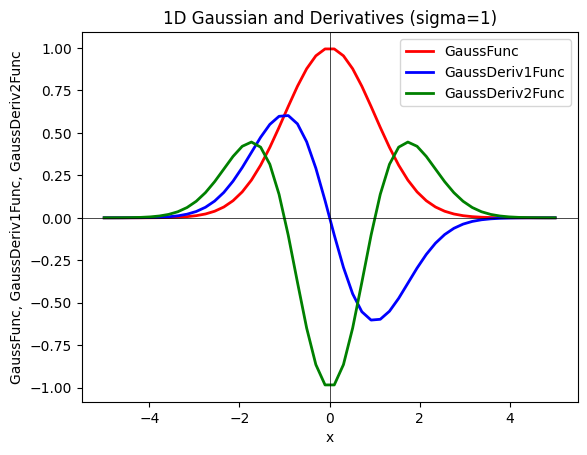

In [8]:
# Con la siguiente figura verificamos que las funciones Gaussianas implementadas son correctas
plt.figure()
xvalues = np.linspace(-5, 5)
yvalues1 = GaussFunc(xvalues,1)
yvalues2 = GaussDeriv1Func(xvalues,1)
yvalues3 = GaussDeriv2Func(xvalues,1)
plt.plot(xvalues, yvalues1, lw=2, color='red',
label='GaussFunc')
plt.plot(xvalues, yvalues2, lw=2, color='blue',
label='GaussDeriv1Func')
plt.plot(xvalues, yvalues3, lw=2, color='green',
label='GaussDeriv2Func')
plt.title('1D Gaussian and Derivatives (sigma=1)')
plt.xlabel('x')
plt.ylabel('GaussFunc, GaussDeriv1Func, GaussDeriv2Func')
plt.axhline(0, lw=0.5, color='black')
plt.axvline(0, lw=0.5, color='black')
plt.legend();

Vemos efectivamente como las gráficas de las funciones concuerdan con la teoría. La Gaussiana tiene máximo $1$ en $0$, es la campana que nos esperábamos. Las derivadas tienen sentido, ya que podemos ver cómo la derivada primera crece hasta llegar a un extremo, en el que la gaussiana sigue creciendo, pero con menor velocidad. Como la Gaussiana crece menos, la derivada decrece hasta alcanzar el origen en el extremo de la Gaussiana. A partir de ese momento la derivada decrece y tiene valor negativo, ya que la Gaussiana empieza a decrecer. Esta misma observación se puede hacer con la derivada segunda.

Es importante mencionar que en el caso de las derivadas, no podemos ver los efectos de la normalización ya que el $\sigma$ es pequeño. Más adelante podremos ver que para $\sigma$ grandes conservamos la escala.

Finalmente, podemos ver cómo el filtro Gaussiano es efectivamente un filtro paso bajo, ya que elimina altas frecuencias y deja pasar bajas frecuencias, suavizando la imagen. La forma de la campana es tal que el filtro calculará para cada píxel una media ponderada de los vecinos, dando más peso a los cercanos. Sin embargo, en las derivadas se observa como son filtros paso alto, ya que eliminan bajas frecuencias y dejan pasar altas frecuencias. Por ejemplo en la derivada primera, vemos cómo al ser la derivada positiva en el semiplano negativo y negativa en el semiplano positivo, se estaría calculando la diferencia entre los vecinos izquierdo y derecho respectivamente, de modo que se realzan los bordes.

<font color=blue> 2. Emplear los siguientes valores de sigma ($\{1, 1.5, 2.5, 6\}$) y los siguientes valores de tamaño de máscara ($\{7, 11, 15\}$), y mostrar el perfil (es decir, la silueta de las máscaras como funciones 1D) para verificar que las máscaras creadas son correctas.

Ahora vamos a mostrar el perfil de las máscaras fijando primero el tamaño de la máscara, y después el sigma. Como tenemos tres órdenes, vamos a dibujar una fila con tres siluetas por cada valor de sigma/máscara fijado.

FIJAMOS PRIMERO EL TAMAÑO DE LA MÁSCARA


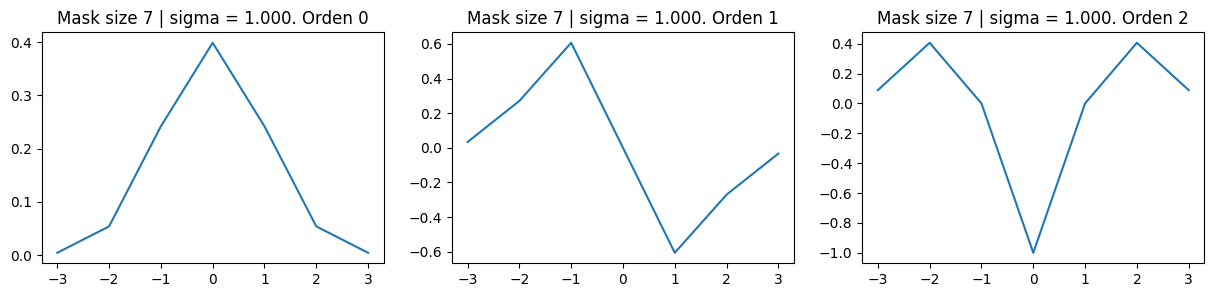

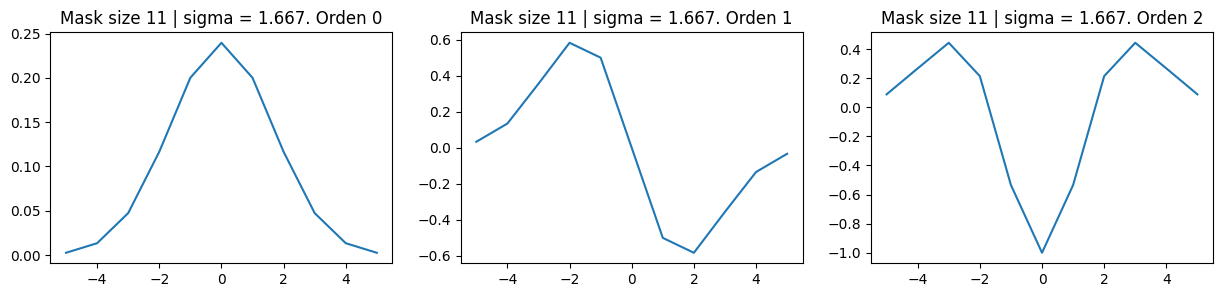

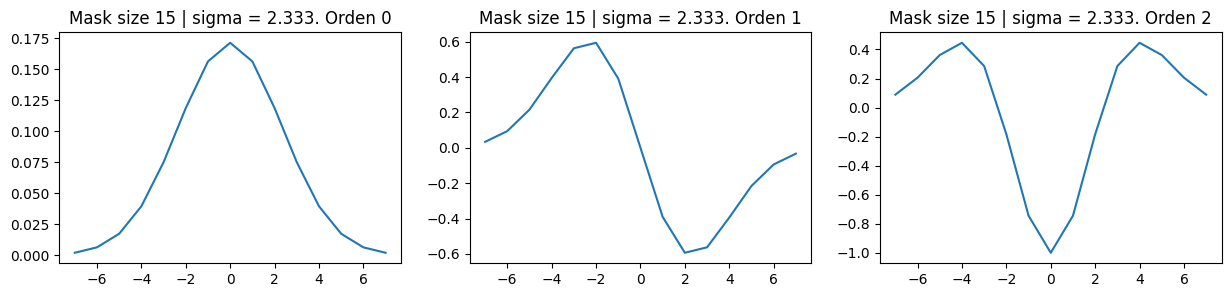

FIJAMOS AHORA EL SIGMA


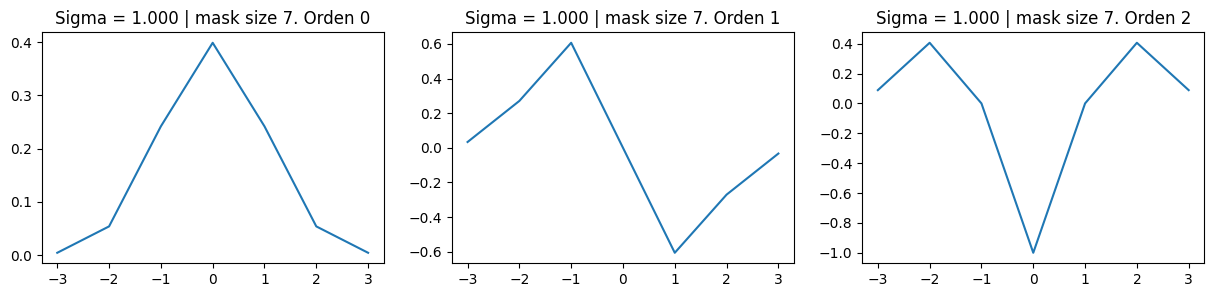

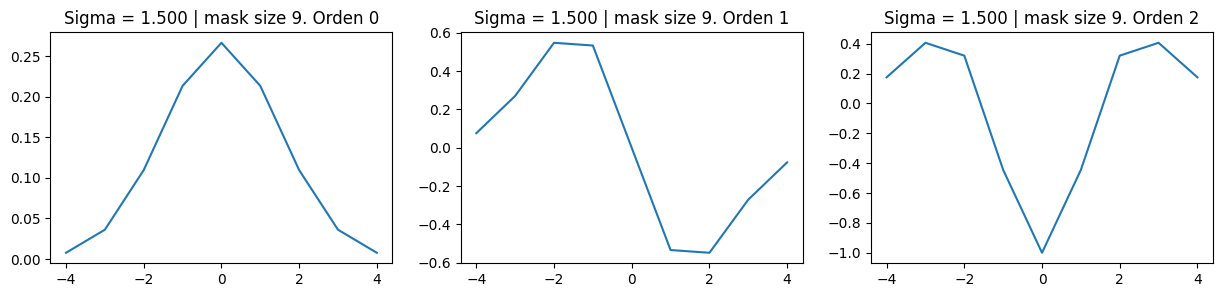

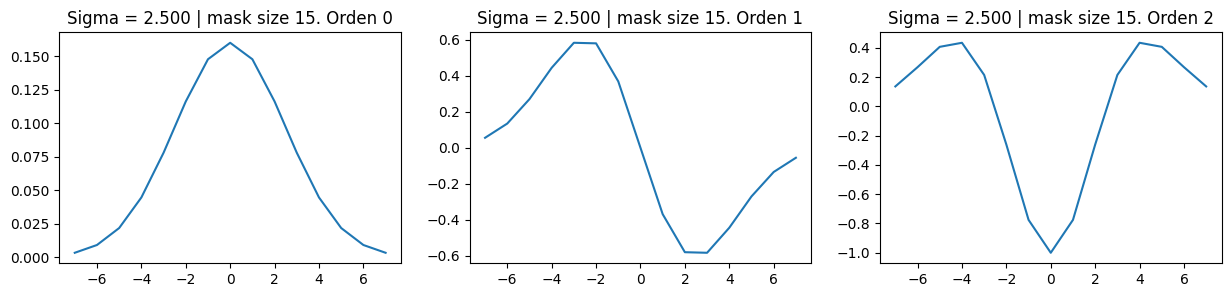

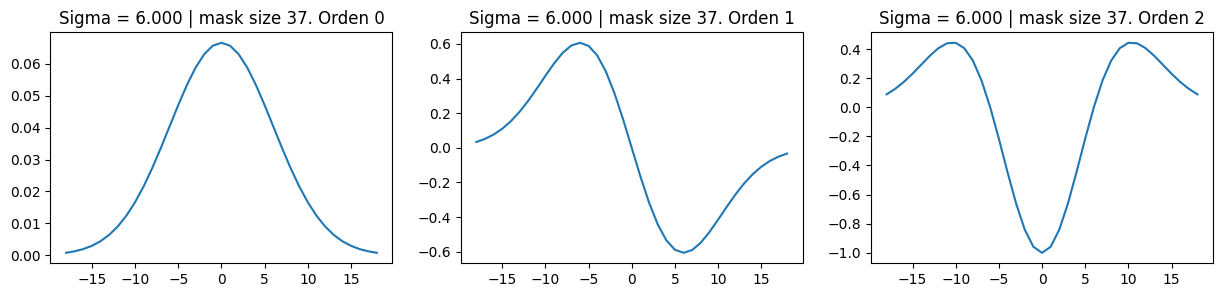

In [9]:
# Valores de sigma y tamaño de máscara
sigma_values = [1, 1.5, 2.5, 6]
size_masks = [7, 11, 15]

plt.rcParams["figure.figsize"] = (15,3) # para ajustar tamaño del ancho y alto (ejes)
print('FIJAMOS PRIMERO EL TAMAÑO DE LA MÁSCARA')
for sizeMask in size_masks:
  for i in range(0,3):
    # Deducimos los parámetros
    sigma = Mask2Sigma(sizeMask)
    # Calculamos k a partir del tamaño de la máscara
    k = (sizeMask-1)//2  # División entera
    # Puntos X (sizeMask puntos entre -k y k)
    xvalues = np.linspace(-k, +k, sizeMask)
    # Puntos Y (gaussiana de orden apropiado)
    yvalues = gaussianMask1D(sigma=sigma, sizeMask=sizeMask, order=i)
    # Subgráfica, 1 fila, 3 columnas
    plt.subplot(1,3, i+1)
    plt.plot(xvalues, yvalues)
    # En el título limitamos a 3 el número de decimales
    plt.title(f"Mask size {sizeMask} | sigma = {sigma:.3f}. Orden {i}")
  plt.show()

print('FIJAMOS AHORA EL SIGMA')
for sigma in sigma_values:
  for i in range(0,3):
    # Deducimos los parámetros
    sizeMask = Sigma2Mask(sigma)
    # Calculamos k a partir del tamaño de la máscara
    k = (sizeMask-1)//2  # División entera
    # Puntos X (sizeMask puntos entre -k y k)
    xvalues = np.linspace(-k, +k, sizeMask)
    # Puntos Y (gaussiana de orden apropiado)
    yvalues = gaussianMask1D(sigma=sigma, sizeMask=sizeMask, order=i)
    # Subgráfica, 1 fila, 3 columnas
    plt.subplot(1,3, i+1)
    plt.plot(xvalues, yvalues)
    # En el título limitamos a 3 el número de decimales
    plt.title(f"Sigma = {sigma:.3f} | mask size {sizeMask}. Orden {i}")
  plt.show()

<font color=blue>

<font color=blue> 3. Describir/explicar/analizar si las formas de dichos kernels tienen sentido y se corresponden con lo que esperaríamos ver.

Observamos que efectivamente, a medida que crece el sigma/máscara crece la máscara/sigma. Además para valores cada vez más grandes de sigma y máscara el perfil se asemeja cada vez más a la función correspondiente, sea la Gaussiana o sus derivadas. Finalmente, cabe resaltar que en las derivadas se observa que aunque crece el sigma/máscara, se mantiene la escala, que es precisamente lo que queríamos. No se observa el estiramiento que debería suceder si no se normaliza. Sin embargo en la Gaussiana si se observa un achatamiento de la máscara, lo cual es normal ya que los elementos de la máscara suman 1, y a medida que crece la gaussiana se estira más.

## B) (1.5 puntos)

<font color=blue> En este apartado se debe leer una imagen en escala de grises (`'zebra.jpg'`) y esta debe ser filtrada mostrando el resultado de la convolución con una Gaussiana, con la primera derivada de la Gaussiana (tanto en $X$ como en $Y$), y con la segunda derivada de la Gaussiana (tanto en $X$ como en $Y$). Para ello, hay que:
1. emplear los siguientes sigmas ($\{0.75,1,2,4,8, 16\}$),
2. usar la función de OpenCV `sepFilter2D()` con las máscaras calculadas a partir de las funciones desarrolladas en el apartado anterior,
3. mostrar todas las imágenes dentro del mismo canvas, tal y como se muestra más abajo,
4. analizar los resultados obtenidos y discutir si se corresponden con lo se esperaría obtener en base a nuestro conocimiento de la teoría.




Queremos realizar una convolución 2D con máscaras 1D. Esto es posible por la separabilidad de la Gaussiana y sus derivadas. Veámoslo en más detalle:

$$G(x,y) = \frac{1}{2\pi \sigma^2} \: \mathrm{exp}\left(-\frac{x^2+y^2}{2\sigma^2}\right) = \frac{1}{\sqrt{2\pi \sigma}} \: \mathrm{exp}\left( -\frac{x^2}{2\sigma^2} \right) \frac{1}{\sqrt{2\pi \sigma}} \: \mathrm{exp}\left( -\frac{y^2}{2\sigma^2} \right) = G_h(x) G_v(y)$$
$$\frac{\partial G(x,y)}{\partial x} = -\frac{x}{\sigma^2} \cdot \frac{1}{2\pi \sigma^2} \: \mathrm{exp}\left( -\frac{x^2}{2\sigma^2} \right) \mathrm{exp}\left( -\frac{y^2}{2\sigma^2} \right) = G_h'(x) G_v(y)$$

Para las derivadas segundas en $X$ e $Y$, de la misma forma nos sale $\frac{\partial^2 G}{\partial x^2} = G_h''(x) G_v(y)$ y $\frac{\partial^2 G}{\partial y^2} = G_h(x) G_v''(y)$

Luego al ser separables las funciones, podemos reducir una convolución 2D en dos 1D (una para filas y otra para columnas), por la propiedad asociativa de la convolución. Esto nos interesa porque nos permite reducir la complejidad del filtrado. El filtrado de una imagen de dimensiones $n \times n$ con un kernel $m \times m$ tiene complejidad $O(n^2m^2)$, pero si el kernel es separable la complejidad se puede reducir a $O(n^2m)$.

Para hacer la convolución con filtro lineal separable, usaremos la función `cv.sepFilter2D`, que recibe como parámetros la imagen, la profundidad, la máscara para las filas y la máscara para las columnas. La profundidad se refiere al tipo usado, si es -1 es el tipo de la imagen, pero nosotros usaremos `cv2.CV_64F`, ya que si el tipo es `uint8`, se satura a $0$ y no se ven valores negativos.

In [10]:
def my2DConv(im, sigma, orders):
  '''
  Esta función recibe una imagen, un sigma y los órdenes de las derivadas
  gaussianas (o de la gaussiana) que se aplican a las filas y las columnas,
  devolviendo la imagen convolucionada
  '''
  # Calculamos máscaras con la función del apartado 1.A
  ddepth = cv2.CV_64F
  mask0 = gaussianMask1D(sigma, order=0)
  mask1 = gaussianMask1D(sigma, order=1)
  mask2 = gaussianMask1D(sigma, order=2)

  # Convolucionamos
  if orders==[0,0]: # Suavizado Gaussiano
    return cv2.sepFilter2D(im, ddepth, mask0, mask0)
  elif orders==[1,0]: # Primera derivada Gaussiana en X
    return cv2.sepFilter2D(im, ddepth, mask1, mask0)
  elif orders==[0,1]: # Primera derivada Gaussiana en Y
    return cv2.sepFilter2D(im, ddepth, mask0, mask1)
  elif orders==[2,0]: # Segunda derivada Gaussiana en X
    return cv2.sepFilter2D(im, ddepth, mask2, mask0)
  elif orders==[0,2]: # Segunda derivada Gaussiana en Y
    return cv2.sepFilter2D(im, ddepth, mask0, mask2)
  else:
    print('error in order of derivative')

Ahora vamos a mostrar las imágenes, usando nuestra función `my2DConv()` y las funciones auxiliares `displayMI_ES()` y `rangeDisplay01()`.

In [11]:
# Sigmas, órdenes y títulos de las convoluciones
sigmas = [0.75,1,2,4,8,16]
vorders = [[0,0], [0,1], [1,0], [0,2], [2,0]]
titles = ['Zero derivative [0,0]', 'First derivative [0,1]', 'First derivative [1,0]',
          'Second derivative [0,2]', 'Second derivative [2,0]']
# Lectura de imagen en greyscale
im=cv2.imread(get_image('zebra.jpg'),0)

# Para cada orden, recorro sigmas y convoluciono imagen con ese sigma
# Luego imprimo las 6 imágenes juntas en un canvas
for i, orders in enumerate(vorders):
  vim = [] # Vector con imágenes convolucionadas
  for sigma in sigmas:
    vim.append(rangeDisplay01(my2DConv(im,sigma,orders),True))
  displayMI_ES(vim,titles[i],2)

Output hidden; open in https://colab.research.google.com to view.

Viendo las imágenes obtenidas, parece que concuerdan con la teoría:


*   **Gaussiana**: vemos como a medida que va creciendo $\sigma$ la imagen se ve cada vez más borrosa. Tiene sentido, ya que la Gaussiana es un filtro paso bajo, y para cada píxel de la imagen calcula el promedio ponderado de los vecinos. A mayor $\sigma$ mayor máscara, luego más vecinos se consideran y más borrosa la imagen.
*   **Primera derivada de la Gaussiana**: vemos como tanto para el eje $X$ como para el eje $Y$ se realza el borde. Las imagenes pierden mucha diversidad de colores, quedándose solo el blanco, negro y el gris (y sus matices) que representan un cambio positivo, negativo y nulo del color (un cambio positivo se refiere a de negro a blanco). También observamos en qué se diferencian las imágenes para el eje $X$ e $Y$, ya que los bordes que se realzan van en el sentido del eje.
*   **Segunda derivada de la Gaussiana**: ídem que la primera, pero la segunda derivada no detecta simplemente la "velocidad" del cambio de color, sino la "aceleración", de modo que la segunda derivada detecta zonas de cambio más abrupto o suave. Aunque también estamos detectando bordes, la diferencia entre la primera y la segunda derivada es que la segunda detecta los detalles más finos y pequeños de la imagen.



## C) (1 punto)

<font color=blue> En este apartado hay que emplear la función de OpenCV `sepFilter2D()` con $\sigma=2.0$ para calcular y mostrar el gradiente (4 imágenes: derivada en $X$, derivada en $Y$, magnitud y orientación) y la Laplaciana de la Gaussiana. Se debe explicar el trabajo realizado, incluyendo las expresiones matemáticas subyacentes y el análisis, al igual que en todos los ejercicios, relativo a si los resultados obtenidos se corresponden con lo esperado.

El gradiente de una imagen $f$ es $\triangledown f = \left[\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}\right]$, que apunta en la dirección del cambio de intensidad más rápido. La fuerza del borde, o la magnitud del gradiente, es $||\triangledown f|| = \sqrt{\left(\frac{\partial f}{\partial x}\right)^2 + \left(\frac{\partial f}{\partial y}\right)^2}$, mientras que la dirección del gradiente es $\theta = \mathrm{tan}^{-1}\left(\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right)$.

Las derivadas $G_x$ y $G_y$, como ya sabemos, son la convolución de la Gaussiana con la derivada de la Gaussiana en su respectivo eje. Entonces la magnitud del gradiente y la orientación se calcularán como $\sqrt{G_x^2+G_y^2}$ y $\mathrm{atan2}(G_y, G_x)$ respectivamente.

In [ ]:
def gradientIM(im,sigma):
  '''
  Dados la imagen y el sigma, la función devuelve el gradiente de
  la imagen: derivada en X, Y, magnitud y orientación
  '''

  # Calculamos derivadas, magnitud y orientación
  dx = my2DConv(im,sigma,[1,0])
  dy = my2DConv(im,sigma,[0,1])
  mag = np.sqrt(dx**2+dy**2)
  ori = np.arctan2(dy, dx)

  return dx,dy,mag,ori

La Laplaciana viene dada por la expresión $L = \sigma^2 (G_{xx}(x,y,\sigma)+G_{yy}(x,y,\sigma))$ donde $\frac{\partial^2 G}{\partial x^2} + \frac{\partial^2 G}{\partial y^2} = G_h''(x) \cdot G_v(y) + G_h(x) \cdot G_v''(y)$. Sabemos que la Laplaciana es separable ya que es la suma de convoluciones 2D separables (porque la Gaussiana y sus derivadas lo son). Luego podemos calcularla con 4 convoluciones 1D, que siguen siendo computacionalmente menos costosas que una convolución 2D, al menos que el kernel sea muy pequeño.

Es importante resaltar que como la Laplaciana es la segunda derivada de la Gaussiana, tiene que multiplicarse por $\sigma^2$ para mantener la escala. Nosotros ya tenemos eso en cuenta al calcular las máscaras con nuestra función `gaussianMask1D()`, en la que ya multiplicamos por $\sigma^2$.

In [ ]:
def laplacianG(im,sigma):
  '''
  Dados la imagen y el sigma, la función devuelve la laplaciana de la imagen
  '''

  # Calculamos sumandos de la laplaciana
  dxx = my2DConv(im,sigma,[2,0])
  dyy = my2DConv(im,sigma,[0,2])

  return dxx+dyy

Ahora vamos a calcular y mostrar el gradiente y la laplaciana para $\sigma=2.0$.

In [ ]:
# Lectura de imagen en greyscale y valor de sigma
im=cv2.imread(get_image('zebra.jpg'),0)
sigma = 2.0

# Calculamos gradiente y laplaciana
dx, dy, mag, ori = gradientIM(im,sigma)
lapl = laplacianG(im,sigma)

# Visualizamos
displayIm(rangeDisplay01(dx, True),'derX',2)
displayIm(rangeDisplay01(dy, True),'derY',2)
displayIm(rangeDisplay01(mag, True),'magnitud',2)
displayIm(rangeDisplay01(ori, True),'orientacion',2)
displayIm(rangeDisplay01(lapl, True),'Laplaciana',2)

Output hidden; open in https://colab.research.google.com to view.

Viendo las imagenes obtenidas, parece que los resultados concuerdan con la teoría.


*   El caso de la derivada $X$ e $Y$ ya se ha discutido en apartados anteriores, vemos que se realzan los bordes en los ejes $X$ e $Y$ respectivamente.
*   En la magnitud del gradiente detectamos bordes en todas las direcciones. Tienen más "fuerza" los que tienen módulo del gradiente mayor, es decir que independientemente de la dirección en la que cambia la intensidad, a mayor "longitud" del vector de cambio más blanco el color. De esta forma obtenemos una imagen en la que las rayas de las zebras están delimitadas por líneas blancas, que representan el cambio de color de negro a blanco en la foto real. En el resto de la foto, como no hay cambios bruscos de intensidad solo hay color negro. Hay que entender que a diferencia de la derivada en $X$ e $Y$, el color será blanco si hay cambio brusco independientemente de si es de blanco a negro o de negro a blanco. Es decir se pierde la información de los colores originales, solo se muestran los cambios bruscos, lo cual para detectar bordes parece ser muy útil.
*   En la orientacion, vemos cómo se detectan las direcciones de los bordes detectados. Se ve cómo las rayas de las zebras que son paralelas tienen colores similares. Esto podría ser útil en algunos casos.
*   El operador Laplaciano mide la divergencia del gradiente. Junto con un suavizado Gaussiano que reduce el ruido en la imagen, obtenemos el Laplaciano de la Gaussiana, como vemos en la imagen obtenida. El LoG es un filtro de paso banda, es decir una mezcla de filtro paso bajo y alto. Elimina frecuencias muy bajas y muy altas, quedandose con una banda de frecuencias medias. De esta forma detectamos bordes y los elementos importantes de la imagen. Por ejemplo comparado con la magnitud, vemos como se detectan mejor las partes de las piernas de las zebras que están en la hierba, y la hierba en la esquina izquierda y a lo largo del borde inferior de la imagen.


## D) (1.5 puntos)

<font color=blue> Implemente una función para realizar "a mano" la convolución separable (es decir, empleando kernels 1D). Dicha función debe recibir como entrada una imagen (con el _padding_ adecuado, en caso de que lo necesite, ya incorporado) y un kernel 1D, y debe proporcionar como salida la imagen convolucionada con el kernel en ambas direcciones.

<font color=blue> Una vez haya implementado la función, realice el suavizado de la imagen `motorcycle.bmp` (usando un _Gaussian kernel size_ de 7, y dejando que sea la propia función de creación del kernel la que determine el $\sigma$ adecuado), y compare el resultado con el de `cv2.GaussianBlur` (en donde se debe optar por la misma estrategia: fijando $ksize=7$ y dejando que sea la propia función de OpenCV la que escoja el sigma). ¿Hay diferencias (sea a nivel de resultado final o de tiempo de ejecución)? En caso afirmativo, ¿a qué se pueden deber?

Vamos a implementar la convolución separable. La función `convolve2D(image, kx, ky)` recibe una imagen con padding y dos kernels, uno por cada eje. Calcula la convolución 2D haciendo la convolución 1D con el kernel del eje $Y$ usando la función `convolve1D(image,kernel)`, después transpone el resultado para así poder aplicar otra vez `convolve1D(image,kernel)` pero ya con el kernel del eje $X$. Finalmente transpone otra vez la imagen para volver a tener los ejes bien.

En cuanto a `convolve1D(image,kernel)`, esta función calcula la convolución 1D con un kernel $Y$. Para ser más eficientes y evitar tener 2 bucles que recorren filas y columnas, lo que hacemos es coger el kernel, ponerlo en forma de vector columna, y copiarlo hasta obtener una matriz de misma anchura que la imagen. De esta forma no hace falta recorrer las columnas, superponemos la matriz sobre la imagen (visualmente), multiplicamos elemento a elemento esa matriz con la submatriz de la imagen correspondiente y de la nueva matriz resultante obtenemos un vector con las sumas de cada columna de esa matriz. Ese vector pasa a ser la fila correspondiente en la matriz de salida que contiene la convolución que queremos. Este proceso se repite para cada fila de la imagen sin padding, es decir empezamos con la matriz centrada en la primera fila donde empieza el padding, y terminamos en la última fila, a partir de la cual iría el padding.

In [ ]:
def convolve1D(image,kernel):
    # Mitad del kernel
    k = (len(kernel)-1)//2
    # Matriz que devolvemos
    output = image.copy()
    # Por ser convolución, damos la vuelta al filtro
    kernel = kernel[::-1]

    # Copiamos el kernel hasta completar la anchura de la imagen
    # y transponemos, obteniendo la matriz mat con la que convolucionamos
    mat = np.tile(kernel, (image.shape[1],1))
    mat = mat.transpose()

    # Hacemos la convolución, recorriendo las filas de la imagen original
    for i in range(k, image.shape[0]-k):
      # Multiplicamos mat con la submatriz de la imagen original
      mult = mat*image[i-k:i+k+1,:]
      # Obtenemos un vector fila con las sumas de las columnas del producto
      res = mult.sum(axis=0)
      # Metemos ese vector en la fila correspondiente de la matriz a devolver
      output[i,:] = res

    return output

def convolve2D(image, kx, ky):
    # Convolución 1D con kernel Y y transposición
    output = convolve1D(image, ky)
    output = output.transpose()
    # Convolución 1D con kernel X y transposición
    output = convolve1D(output, ky)
    output = output.transpose()

    return output

Ahora vamos a suavizar `motorcycle.bmp` con un kernel Gaussiano de $sizemask=7$ y compararemos con `cv2.GaussianBlur()` con mismo parámetro. Antes de eso añadiremos $0$-padding a la imagen (por ninguna razón en concreto escogemos este padding antes que otros). Después de aplicar los suavizados quitamos el padding. `cv2.GaussianBlur()` recibe como parámetros la imagen, las dimensiones del kernel en una tupla, y sigmaX, que al ponerse a $0$ será calculado a partir del tamaño del kernel. También vamos a medir los tiempos de ejecuciones de `convolve2D()` y `cv2.GaussianBlur()` para compararlos.

15.4 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
333 µs ± 5.93 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


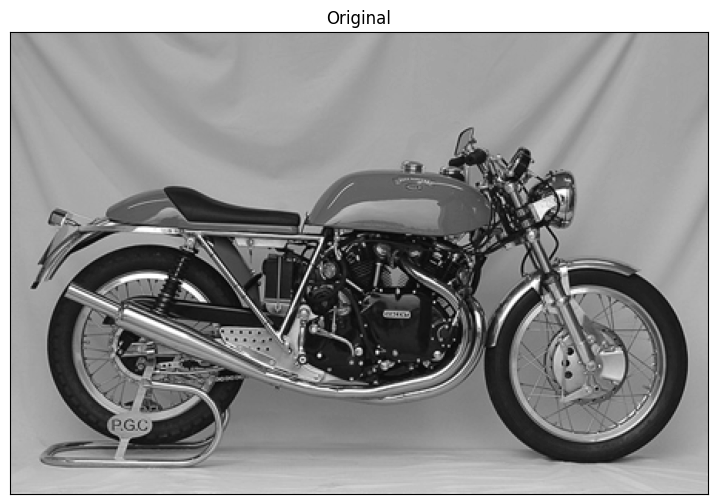

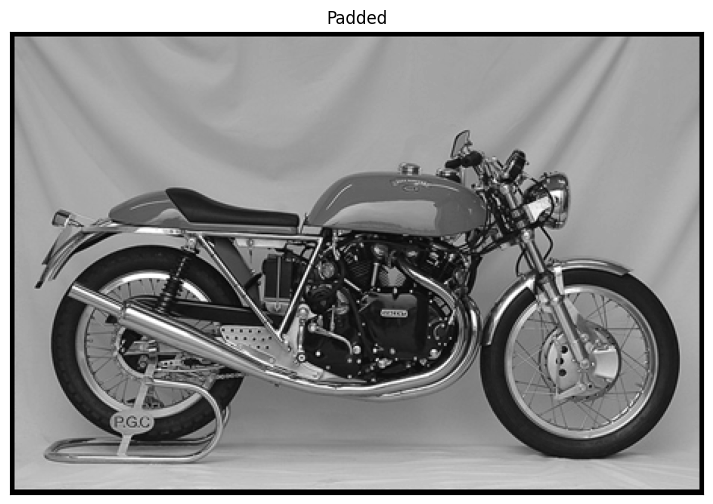

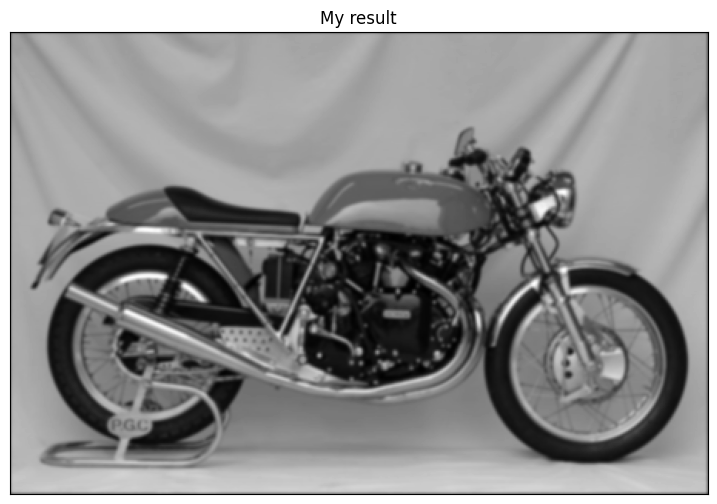

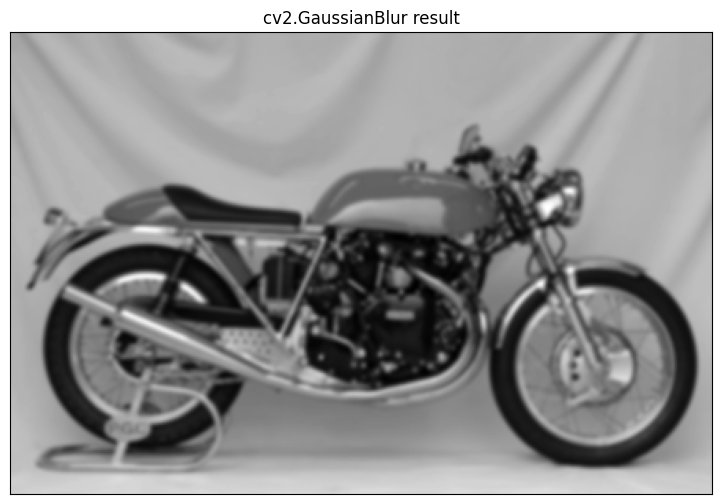

In [ ]:
filename = 'motorcycle.bmp'

# Lectura de imagen en greyscale
im=cv2.imread(get_image(filename),0)
# Kernel size, k y máscara Gaussiana
sizeMask = 7
k = (sizeMask-1)//2
mask = gaussianMask1D(sizeMask = sizeMask, order=0)

# Añadimos 0-padding
padded_im = cv2.copyMakeBorder(im, k, k, k, k, cv2.BORDER_CONSTANT, value=0)
# Convolucionamos
%timeit myconv_im = convolve2D(padded_im, mask, mask)
%timeit blur_im = cv2.GaussianBlur(im, (sizeMask, sizeMask), 0)
myconv_im = convolve2D(padded_im, mask, mask)
blur_im = cv2.GaussianBlur(im, (sizeMask, sizeMask), 0)
# Quitamos el padding
myoutput_im = myconv_im[k:-k, k:-k]
blur_output_im = blur_im[k:-k, k:-k]
# Visualizamos
displayIm(rangeDisplay01(im, True),'Original',2)
displayIm(rangeDisplay01(padded_im, True),'Padded',2)
displayIm(rangeDisplay01(myoutput_im, True),'My result',2)
displayIm(rangeDisplay01(blur_output_im, True),'cv2.GaussianBlur result',2)

Viendo los resultados obtenidos, nos sale que nuestra función tarda milisegundos mientras que la de OpenCV tarda microsegundos. Parece que la de OpenCV es más eficiente. También se nota una diferencia en los resultados obtenidos, la imagen de OpenCV parece ser levemente más borrosa.

Esto puede ser porque OpenCV valora más la eficiencia que la precisión. A lo mejor su forma de calcular sigma a partir del tamaño de la máscara es distinta de la nuestra, menos matemáticamente "pura". También es posible que se use una precisión menor para agilizar los cálculos, o que se discretize la Gaussiana de otra forma.

Consultando la documentación de OpenCV de hecho vemos que efectivamente la forma de discretizar la máscara Gaussiana es distinta. Se hace en la función [getGaussianKernel()](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa), donde se ve que la fórmula para calcular el sigma es distinta de la nuestra.

## E) (0.5 puntos)

<font color=blue> Las herramientas de IA generativa son de gran utilidad tanto para estudiantes como para docentes. No obstante, resulta fundamental tener una actitud crítica y asumir desde el principio que las respuestas proporcionadas por estas herramientas pueden ser factualmente incorrectas (véase,  por ejemplo, https://elpais.com/tecnologia/2024-09-25/los-nuevos-modelos-de-ia-como-chatgpt-persiguen-la-superinteligencia-pero-no-logran-ser-fiables-ni-en-preguntas-bobas.html). En este sentido, vale la pena recordar lo que indica la guía de la UGR (https://ceprud.ugr.es/formacion-tic/inteligencia-artificial): _"Debes revisar siempre la salida que genera y las posibles referencias que utilice. [...] Mejora tus resultados con la IAGen aprendiendo a usarla y a comunicarte con ella de manera adecuada. Pero no dejes que piense por ti."_

<font color=blue> En este apartado trabajaremos de forma crítica la utilidad de estas herramientas. Para ello, el alumnado debe emplear ChatGPT (https://chatgpt.com/) para consultar _"en qué consiste y para qué sirve la normalización de escala, así como por qué, en dicha normalización de escala, se multiplica por $\sigma^n$, siendo $n$ el orden de derivada"_. No se trata meramente de copiar lo que indique ChatGPT como salida, sino de analizar y matizar su respuesta, confrontándola con otras lecturas y lo que el estudiante sabe de la teoría, indicando en qué aspectos dicha respuesta puede considerarse correcta y en qué aspectos quizás no lo es.

Explica

# **Ejercicio 2**:  Pirámides Gaussianas y Laplacianas (3.5 puntos)







## A) (1.5 puntos)

<font color=blue>Construya una pirámide Gaussiana de 4 niveles empleando máscaras Gaussianas de tamaño $7\times7$. No se permite emplear las funciones `pyrUp()` y `pyrDown()` de OpenCV, ni tampoco `cv2.resize()`.

Esta función auxiliar nos ayuda visualizar una pirámide Gaussiana. Primero crea un array de mismo tamaño que la imagen, luego pega horizontalmente la mitad izquierda de esa imagen, para así tener un array en el que podamos tener toda la pirámide. Después coloca en ese array la primera imagen, a su derecha pega la segunda, y procede a iterar sobre las imagenes que quedan, pegandolas debajo de las anteriores, a la derecha de la primera.

In [ ]:
'''
This function displays a pyramid of images, providing as input the list of images to display.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1, cv2.resize(im1,(im1.shape[0]//2,im1.shape[1]//2),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//4,im1.shape[1]//4),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//8,im1.shape[1]//8),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//16,im1.shape[1]//16),cv2.INTER_LINEAR)]

displayPyramid(images, title='Piramide de Manzanas')

'''
def displayPyramid(vim, title='result'):
  temp = np.zeros_like(vim[0])
  if np.mod(temp.shape[1],2)==0:
    h = temp[:, :temp.shape[1]//2]
  else:
    h = temp[:, :(temp.shape[1]//2)+1]
  out = np.hstack((temp, h))
  top = 0
  out[0:vim[0].shape[0], 0:vim[0].shape[1]] = vim[0]
  left = vim[0].shape[1]
  for i in range(1, len(vim)):
    out[top:top+vim[i].shape[0], left:left + vim[i].shape[1]] = vim[i]
    top += vim[i].shape[0]
  displayIm(out, title)

Con la siguiente función creamos una pirámide Gaussiana. La pirámide es un vector de imágenes, con la primera imagen la que nos viene como argumento de entrada. Calcularemos el sigma a partir del tamaño del kernel y generamos los siguientes niveles de la pirámide, suavizando con kernel Gaussiano usando la función `my2DConv()` y subsampleando, es decir quitando la mitad de las filas y la mitad de las columnas.

Finalmente usamos como ejemplo la imagen de las zebras y visualizamos la pirámide Gaussiana con ellas.

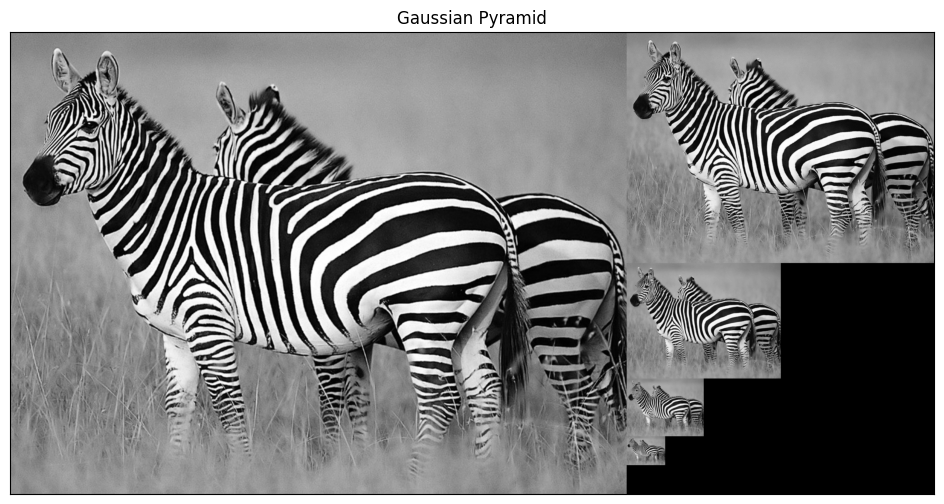

In [ ]:
def pyramidGauss(im,sizeMask=7, nlevel=4):
  '''
  Esta función calcula la pirámide Gaussiana dada una imagen,
  el tamaño del kernel gaussiano y el número de niveles de la pirámide
  '''
  # La pirámide con la imagen como primer elemento
  pyr = [im]
  # Deduzco sigma del tamaño del kernel
  sigma = Mask2Sigma(sizeMask)
  # Genero la pirámide
  for i in range(nlevel):
    # Suavizo último elemento de la pirámide
    smooth_im = my2DConv(pyr[i],sigma,[0,0])
    # Subsampling, quito cada segunda columna y fila con slicing de paso 2
    red_im = smooth_im[::2,::2]
    # Añado la imagen a la pirámide
    pyr.append(red_im)
  return pyr

# Leo imagen
im=cv2.imread(get_image('zebra.jpg'),0)
# Creo pirámide
pyrG = pyramidGauss(im,sizeMask=7, nlevel=4)
# Visualizo
displayPyramid(pyrG,'Gaussian Pyramid')


Tal y como esperábamos, obtenemos imagenes de zebras cada vez más pequeñas ($1/4$ de la imagen anterior) que se ven bien. Discutiremos más adelante por qué se ven bien suavizando antes de hacer subsampling y se ve mal sin suavizado.

## B) (1 punto)

<font color=blue>Use su código del apartado anterior para implementar una función que permita construir una pirámide Laplaciana de 4 niveles.

La pirámide Laplaciana se contruye a partir de la pirámide Gaussiana en orden de menor a mayor. La imagen más pequeña de la Gaussiana es la imagen más pequeña de la Laplaciana. Se coge esta, se expande, y después se resta de la imagen de la pirámide Gaussiana del siguiente nivel, y el resultado de esa diferencia pasa a ser la siguiente imagen de la pirámide Laplaciana. De esta forma se repite hasta llegar al último nivel.

A la hora de visualizar, es importante tener en cuenta que hay que usar `rangeDisplay01()` para visualizar correctamente. Si no normalizamos, al hacer la resta en la pirámide Laplaciana nos podemos quedar con valores negativos. En vista de la implementación de `displayPyramid()`, que a su vez invoca a `displayIm()`, esto no supone un problema ya que en caso de tener valores negativos se llama a `rangeDisplay01()`, que normaliza al intervalo $[0,1]$. Pero si no hay valores negativos, lo que hacemos es quedarnos con valores bastante pequeños. Esto hace que la imagen quede gris oscuro y sea difícil distinguir algo en ella. Por eso es necesario usar `rangeDisplay01()`, para escalar los valores a un rango en el que se perciban mejor las diferencias entre píxeles por el ojo humano.

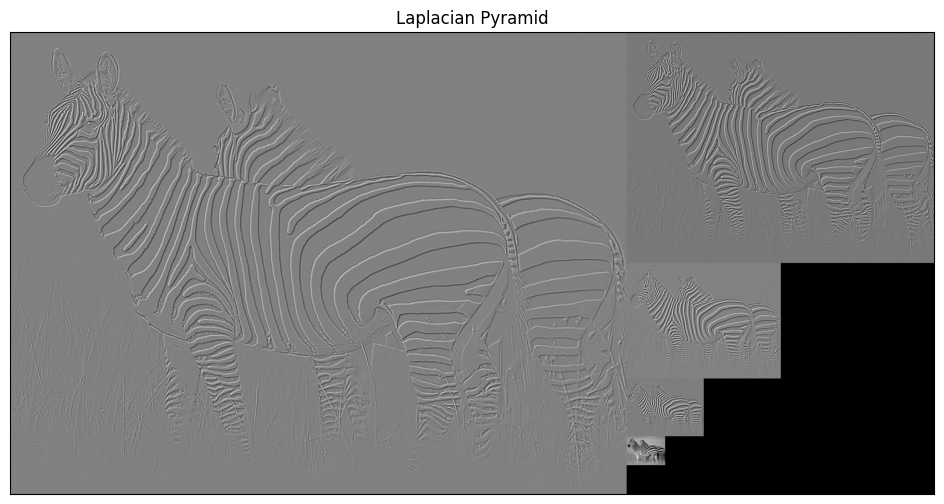

In [ ]:
def pyramidLap(im, sizeMask,nlevel=4,flagInterp=cv2.INTER_LINEAR  ):
  '''
  Esta función calcula la pirámide Laplaciana dada una imagen,
  el tamaño del kernel gaussiano, el número de niveles de la pirámide
  y el tipo de interpolación a usar
  '''
  # Pirámide Gaussiana
  pyrG = pyramidGauss(im,sizeMask,nlevel)
  # Partimos del último elemento de la Gaussiana
  pyrL = [pyrG[-1]]
  for i in range(nlevel):
    # Expando desde el final de la pirámide Gaussiana
    exp_im = cv2.resize(pyrG[nlevel-i],(pyrG[nlevel-i-1].shape[1],pyrG[nlevel-i-1].shape[0]),flagInterp)
    # Añado a la pirámide Laplaciana la diferencia de la imagen de la Gaussiana y la expandida
    pyrL.append(pyrG[nlevel-i-1] - exp_im)
  return pyrL[::-1] # Devuelvo la pirámide en el orden inverso

# Leo imagen
im=cv2.imread(get_image('zebra.jpg'),0)
# Creo pirámide
pyrL = pyramidLap(im,sizeMask=7, nlevel=4)
# Visualizo, importante usar rangeDisplay01()
displayPyramid([rangeDisplay01(im, True) for im in pyrL],'Laplacian Pyramid')

Como podemos ver, la imagen Laplaciana tiene como última imagen la última de la pirámide Gaussiana. El resto de las imagenes se han generado según el proceso descrito anteriormente. Más adelante veremos qué utilidad tiene la pirámide Laplaciana.

## C) (0.5 puntos)

<font color=blue>Ahora realice la misma operación que en los apartados anteriores, pero sin suavizar antes de hacer subsampling a la hora de crear la pirámide Gaussiana. ¿Hay diferencias visuales en la pirámide Laplaciana generada? ¿A qué se pueden deber estas?

Vamos a hacer lo mismo que en los apartados anteriores, pero sin suavizar. Visualizaremos tanto la pirámide Gaussiana resultante como la Laplaciana.

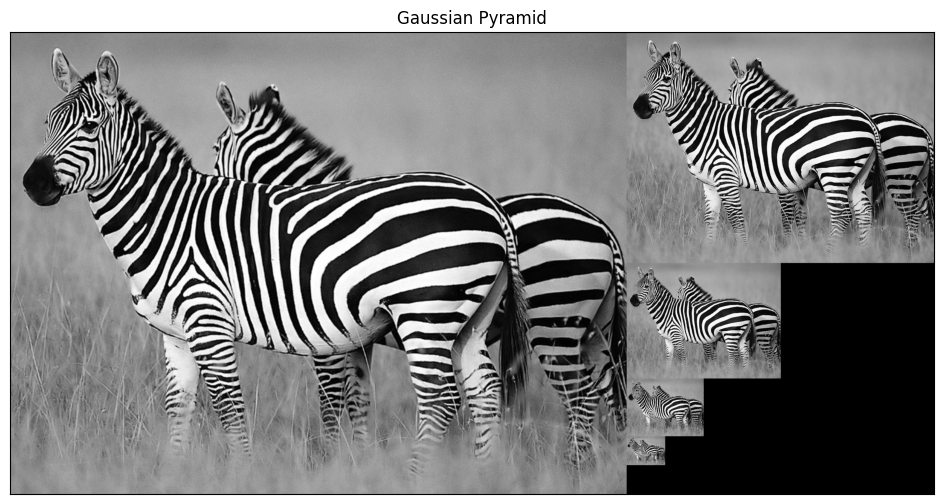

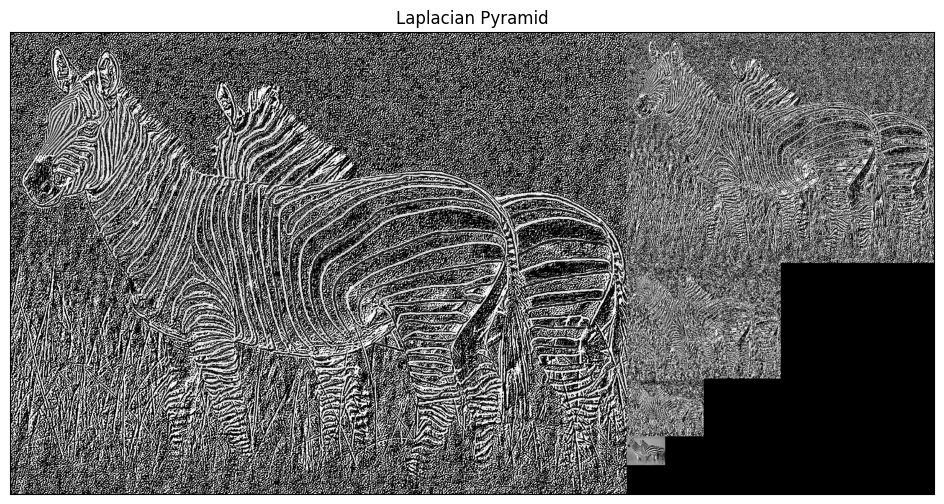

In [ ]:
# Leo imagen
im=cv2.imread(get_image('zebra.jpg'),0)

# La pirámide con la imagen como primer elemento
pyrG2 = [im]
nlevel=4

# Genero la pirámide
for i in range(nlevel):
  # Subsampling, quito cada segunda columna y fila con slicing de paso 2
  red_im = pyrG2[i]
  red_im = red_im[::2,::2]
  # Añado la imagen a la pirámide
  pyrG2.append(red_im)

# Partimos del último elemento de la Gaussiana
pyrL2 = [pyrG2[-1]]
for i in range(nlevel):
  # Expando desde el final de la pirámide Gaussiana
  exp_im = cv2.resize(pyrG2[nlevel-i],(pyrG2[nlevel-i-1].shape[1],pyrG2[nlevel-i-1].shape[0]),cv2.INTER_LINEAR)
  # Añado a la pirámide Laplaciana la diferencia de la imagen de la Gaussiana y la expandida
  pyrL2.append(pyrG2[nlevel-i-1] - exp_im)

# Visualizo
displayPyramid(pyrG2,'Gaussian Pyramid')
# Visualizo, importante usar rangeDisplay01()
displayPyramid([rangeDisplay01(im, True) for im in pyrL2[::-1]],'Laplacian Pyramid')

En efecto, vemos cómo cambia considerablemente la pirámide Laplaciana, pero en la pirámide Gaussiana a primera vista no se ve qué diferencia hay. Vamos a hacer un zoom de la última imagen de la pirámide Gaussiana con y sin smoothing.

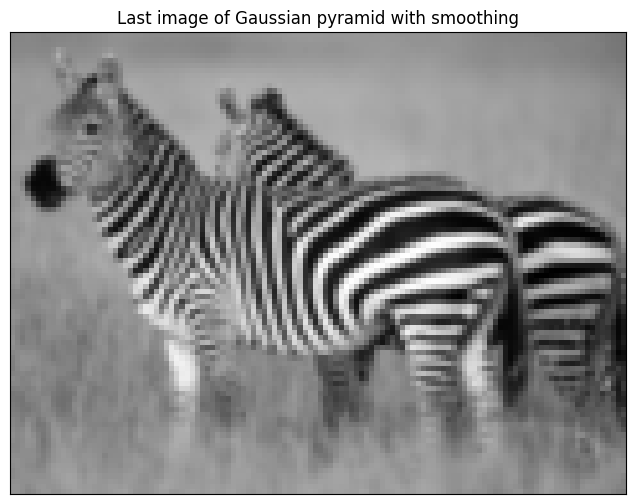

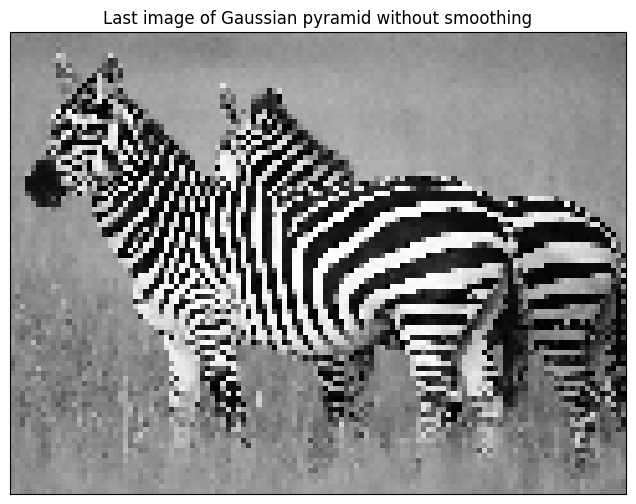

In [ ]:
displayIm(pyrG[-1], 'Last image of Gaussian pyramid with smoothing')
displayIm(pyrG2[-1], 'Last image of Gaussian pyramid without smoothing')

¡Ahora sí que se ve la diferencia! Vamos a discutir por qué:

Cuando construimos la pirámide Gaussiana, reducimos la resolución a un $1/4$ de al imagen anterior en la pirámide. Eso se hace con subsampling, en concreto quitando cada segunda fila y columna, pero si hacemos esto sin más se produce el efecto de aliasing debido a frecuencias altas en la imagen. El aliasing se produce cuando hacemos sampling de frecuencias altas con una frecuencia menor que la frecuencia de Nyquist ($\mathrm{frec} >2 \cdot \mathrm{max}$ en la imagen). Si no sampleamos con suficiente frecuencia, obtenemos una señal sesgada ya que perdemos información importante. Como desechamos píxeles sin hacer ningún tipo de filtración, la imagen resultante mantiene esas frecuencias altas que a una resolución menor crean un efecto de "pixelación" y proporcionan una imagen "crujiente". Dicho de otra forma, estamos intentando empaquetar un conjunto de objetos en un contenedor más pequeño. Si lo hacemos desechando los que no caben, como algunos de esos objetos son más altos que otros, se notará más la diferencia. Precisamente por eso es necesario suavizar primero con un filtro paso bajo, en concreto una Gaussiana. El suavizado disminuye las frecuencias altas, haciendo que la imagen sea más borrosa, y al hacerse downsampling retenemos la información de la imagen original pero con una resolución menor. De esta forma la imagen resultante se ve suave como el original. Además, según el teorema de sampling de Shannon, al suavizar obtenemos píxeles redundantes que se pueden desechar sin pérdida de información.

En cuanto a la Laplaciana, discutiremos en el apartado siguiente la utilidad que tiene. Aquí simplemente mencionamos que por construcción de la pirámide Laplaciana, se entiende por qué con suavizado la Laplaciana aparece más suave y sin suavizado más "pixelada". Es lo mismo que la Gaussiana, a partir de la cual se construye la Laplaciana.

## D) (0.5 puntos)

<font color=blue>Implemente ahora una función para reconstruir la imagen codificada en la pirámide Laplaciana del apartado 2.B. Verifique que es posible obtener una copia exacta de la imagen original. Para ello, calcule el error de reconstrucción como el _Root Mean Squared Error_ (RMSE) entre los niveles de intensidad de la imagen original y la imagen reconstruida.

La utilidad de la Laplaciana consiste en que podemos reconstruir una imagen a partir de la pirámide Laplaciana de forma exacta. La ventaja está en que guardando solo la Laplaciana conseguimos comprimir una imagen y ahorrar espacio. La forma en la que se reconstruye una imagen a partir de la Laplaciana es la siguiente:


1.   Recorro la Laplaciana desde el final, cojo la última imagen de la Laplaciana (también última de la Gaussiana) y la expando.
2.   El resultado de la expansión se suma a la imagen de la Laplaciana el siguiente nivel.
3.   Se vuelve repetir el proceso para la imagen producita: expansión, suma, etc.

La reconstrucción perfecta no depende ni del sigma ni de la interpolación usada. Por el teorema de Nyquist-Shannon, al suavizar tenemos píxeles redundantes que se desechan sin pérdida de información. Luego en la pirámide Laplaciana lo que tenemos es una versión de la imagen original reducida en el último nivel, y todos los detalles con frecuencias altas a distintas escalas en los niveles restantes de la pirámide. Realmente mantenemos toda la información para una reconstrucción perfecta, solo que ahora podemos comprimir la imagen y guardarla en menos espacio.

Vamos a implementar la función para reconstruir la imagen original a partir de la Laplaciana y comprobar que la reconstrucción es perfecta, midiendo el _Root Mean Squared Error_ (RMSE). Visualizaremos todo el proceso de reconstrucción, mostrando cada imagen obtenida en el proceso, y compararemos visualmente la reconstrucción final y la imagen original.




In [ ]:
def reconstructLap(pyL,flagInterp):
  '''
  Esta función reconstruye una imagen a partir de su pirámide Laplaciana
  '''
  # Una imagen inicializada a 0 de mismas dimensiones que la última imagen
  # de la Laplaciana
  im = np.zeros_like(pyL[-1])
  # Vector de reconstrucción
  pyrRec = []

  # Reconstruimos, iterando desde el final de la laplaciana
  # En la primera iteración im está inicializada a 0 con mismas dimensiones que
  # la última imagen de la laplaciana, de modo que al sumar no cambia de valor
  # y al vector se añade la última imagen de la laplaciana.
  for lap_im in pyL[::-1]:
    # Expandimos
    exp_im = cv2.resize(im,(lap_im.shape[1],lap_im.shape[0]),flagInterp)
    # Sumamos lo expandido con la laplaciana
    im = lap_im + exp_im
    # Añadimos al vector de reconstrucción
    pyrRec.append(im)
  return pyrRec

# Leo imagen
im=cv2.imread(get_image('zebra.jpg'),0)
# Construyo Laplaciana
pyrL = pyramidLap(im,sizeMask=7, nlevel=4)
# Reconstruyo
pyrRec = reconstructLap(pyrL,cv2.INTER_LINEAR)
recons = pyrRec[-1]

# Visualizo
displayIm(rangeDisplay01(pyrRec[0], True),'Base Image',2)
for i in range(1, len(pyrRec)):
  displayIm(rangeDisplay01(pyrRec[i], True),f'Reconstruction {len(pyrRec)-i}',2)
displayIm(rangeDisplay01(pyrRec[-1], True),'Final Reconstruction',2)
displayIm(rangeDisplay01(im, True),'Original',2)
# Error RMSE
print('Error per pixel',np.sqrt(np.mean((im - np.round(recons)) ** 2)))

Output hidden; open in https://colab.research.google.com to view.

Como podemos ver, tanto visualmente como numéricamente confirmamos que la reconstrucción es perfecta. Esto demuestra la utilidad de la Laplaciana para comprimir imágenes sin pérdidad de información.

# **Ejercicio 3: Imágenes Híbridas** (1.5 puntos)

<font color=blue>Este ejercicio se basa en el siguiente trabajo: $\textit{Oliva, A., Torralba, A., & Schyns, P. G. (2006). Hybrid images. ACM Transactions on Graphics (TOG), 25(3), 527-532}$ (https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf). Vamos a aprender cómo el sistema visual humano extrae información sobre un objeto en función de la distancia. Para ello, construimos una imagen híbrida a partir de dos imágenes de objetos diferentes. Mezclando adecuadamente parte de las altas frecuencias de una imagen con parte de las bajas frecuencias de otra imagen, obtenemos una imagen híbrida que muestra diferentes percepciones con la distancia. El sigma empleado para filtrar ambas imágenes (tanto la de alta como la de bajas frecuencias) es el aspecto clave para seleccionar el rango de frecuencias altas y bajas de cada imagen. Cuanto mayor sea el valor sigma, mayor será la eliminación de altas frecuencias de la imagen. Se recomienda elegir este valor por separado para cada una de las imágenes y, de hecho, seguramente sea posible (y deseable) el tener distintos valores para distintos pares de imágenes.

<font color=blue>Aspectos de importancia en relación a este ejercicio:

1. Como mínimo, se deben generar las imágenes híbridas correspondientes a `'cat.bmp'+'dog.bmp'`, `'submarine.bmp'+'fish.bmp'` y `'marilyn.bmp'+'einstein.bmp'` (todas ellas en escala de grises). Se debe emplear una pirámide Gaussiana con 5 niveles para mostrar el efecto obtenido.
2. No es necesario seguir al pie de la letra el artículo de referencia y operar en el dominio de la frecuencia (Fourier). Basta con operar en el dominio del espacio, como hemos hecho en todos los demás apartados de esta práctica.
3. Se debe explicar con claridad el criterio empleado para escoger la imagen de altas y la imagen de bajas frecuencias, así como el proceso seguido para filtrar la imagen de altas frecuencias y la de bajas frecuencias (incluyendo la elección de los sigmas finalmente utilizados; es decir, no sería suficiente indicar sucintamente que "se procedió por medio de prueba y error hasta obtener el sigma final").

Tras leer el artículo, sabemos que para crear una imagen híbrida buena lo que queremos es una imagen que de cerca se vea como una cosa y de lejos como otra. Esto se hace combinando dos imágenes, una que contribuye sus frecuencias altas, y otra que contribuye las bajas. Cuando estemos cerca veremos la primera imagen ya que tiene altas frecuencias, mientras que la segunda imagen en el caso de una imagen híbrida perfecta o se percibirá como ruido o se mezclará con los bordes de la primera. Cuando estemos lejos todo será del revés, la primera imagen se disuelve dejando que la segunda imagen la domine con sus frecuencias bajas. Nuestro objetivo, por consiguiente, es obtener una imagen híbrida en la que las dos imágenes no entren en conflicto y permiten que una domine a la otra dependiendo de la distancia entre la imagen y el observador.

Por comodidad del observador, vamos a visualizar las imágenes híbridas con una pirámide Gaussiana, de modo que se simulará una distancia variable entre el observador y lo observado, lo cual permitirá no tener que distanciarse de la pantalla del ordenador para evaluar las imágenes híbridas.

La función que calcula la imagen híbrida recibe la imagen de la que se extraerán las frecuencias bajas, la imagen de la que se extraerán las frecuencias altas, y los respectivos sigmas. El procedimiento es muy simple, la imagen que contribuye sus frecuencias bajas se suavizará, eliminándose sus frecuencias altas. En el caso de la imagen que contribuye las frecuencias altas, esta también se suavizará, y el resultado de este suavizado se restará a la imagen antes de suavizar, dejando de esta forma las frecuencias altas y eliminando las bajas. En resumen, cuanto mayor sea el sigma, tanto el primero como el segundo, más se suavizará o realzará respectivamente.

In [ ]:
def hybridImage(imLow, imHigh, sigmaLow, sigmaHigh):
  '''
  Esta función devuelve una imagen híbrida a partir de dos imágenes y dos sigmas.
  Una imagen contribuye sus frecuencias bajas y otra sus frecuencias altas.
  '''
  # Suavizo imagen
  imLow_processed = my2DConv(imLow,sigmaLow,[0,0])
  # Elimino las frecuencias bajas de la imagen restandole el suavizado
  imHigh_processed = imHigh - my2DConv(imHigh,sigmaHigh,[0,0])
  return imLow_processed + imHigh_processed # Superpongo

Por comodidad voy a crear una función para todo el proceso de lectura de imágenes, cálculo de la imagen híbrida y visualización de la pirámide Gaussiana. La función tiene una bandera para mostrar o no mostrar las imágenes originales, a partir de las cuales se hace la híbrida. La pirámide Gaussiana se hará como en ejercicios anteriores con tamaño del kernel $7$ y $5$ niveles.

In [ ]:
def displayHybridPyramid(imLowName, imHighName, sigmaLow, sigmaHigh, original=False):
  '''
  Esta función muestra la pirámide Gaussiana de una imagen híbrida, dados los
  nombres de las imágenes y los sigmas. El flag original indica si se muestra
  o no la imagen original o no.
  '''
  # Leo imágenes
  imLow = cv2.imread(get_image(imLowName), 0)
  imHigh = cv2.imread(get_image(imHighName), 0)
  # Quito extensiones
  imLowName = imLowName.split('.')[0]
  imHighName = imHighName.split('.')[0]
  # Muestro original
  if original:
    displayIm(rangeDisplay01(imLow, True),imLowName,2)
    displayIm(rangeDisplay01(imHigh, True),imHighName,2)
  # Imagen híbrida
  hybrid = hybridImage(imLow, imHigh, sigmaLow, sigmaHigh)

  # Pirámide Gaussiana
  pyrG = pyramidGauss(hybrid, sizeMask=7, nlevel=5)

  # Visualizo
  displayPyramid(pyrG,f'Hybrid-{imLowName}{imHighName} (sigma {sigmaLow} and sigma {sigmaHigh})')


Para calcular las imágenes híbridas, primero tengo que decidir cual de las dos imágenes contribuye frecuencias bajas y cual frecuencias altas. El criterio para elegir es, tal y como viene explicado en el artículo, que para las frecuencias altas es mejor elegir la imagen con bordes más realzados, mientras que para las frecuencias bajas la imagen más suave. Una vez hecha esta elección, vamos a encontrar los valores de sigma más adecuados. Para eso voy a definir el criterio con el que evalúo lo "buena" que es una imagen híbrida:
1. Si en el nivel 0 de la pirámide Gaussiana predomina la imagen con frecuencias altas y casi no puedo determinar cómo es la imagen de frecuencias bajas.
2. Si en el nivel 4 y 5 predomina la imagen con frecuencias bajas, y es prácticamente imposible distinguir la otra imagen.

El proceso de búsqueda de los sigmas adecuados consiste en probar primero con unos valores de sigma por defecto (por ejemplo, $5$ y $3$), y a partir de allí escogemos los valores de sigma que queremos explorar, en función de si hace falta suavizar más y/o realzar más.

En la primera pareja, tenemos un gato y un perro. Está claro que el gato es más "suave", ya de por si lo es bastante, pero el perro además tiene un pelo en los lados que combina negro y blanco creando muchas frecuencias altas.

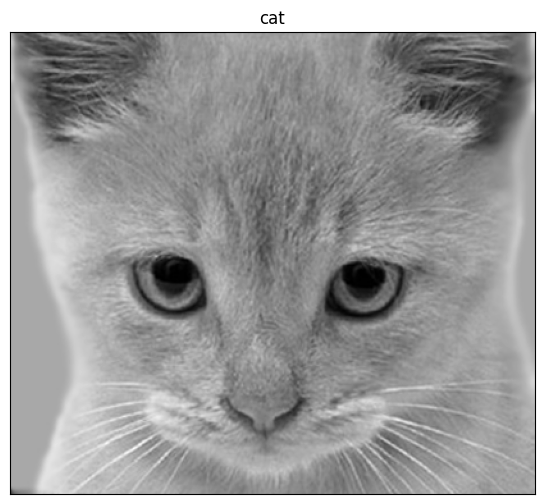

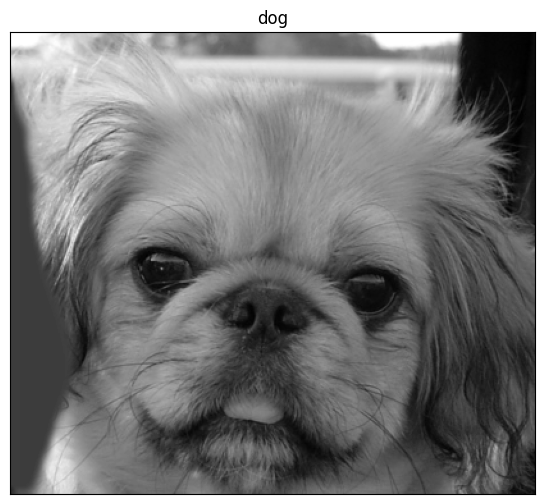

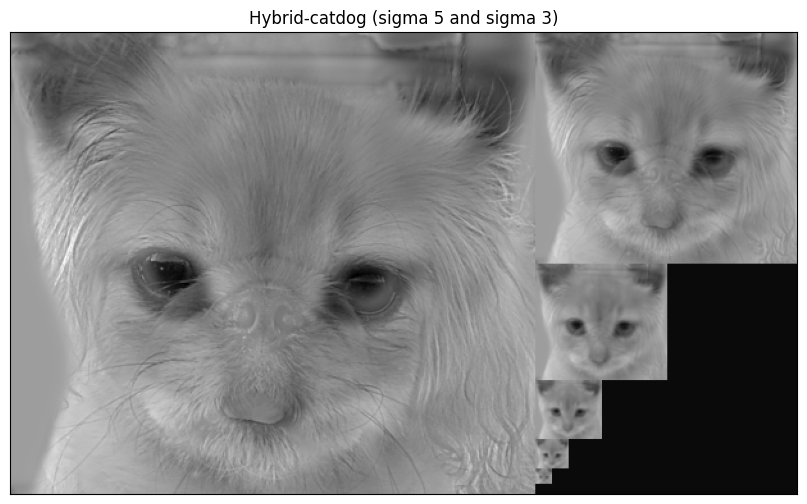

In [ ]:
displayHybridPyramid('cat.bmp','dog.bmp',5,3, original=True)

El resultado de esta primera prueba es que no se realza suficientemente el perro y el gato debería suavizarse más. Vamos a probar con los siguientes valores de sigma:

In [ ]:
for i1 in [7, 9,11]:
  for i2 in [5, 7, 9]:
    displayHybridPyramid('cat.bmp','dog.bmp',i1,i2)

Output hidden; open in https://colab.research.google.com to view.

Tenemos varias opciones que no están mal, pero me parece que la mejor es sigma $9$ y sigma $5$. El gato se ve bien en los últimos niveles, y el perro se ve casi perfecto en el nivel 0. Se ve cómo en muchas pirámides en los últimos niveles sobresale demasiado el morro del perro, lo cual significa que se sobresalen demasiado las frecuencias altas del perro. Veamos el resultado final:

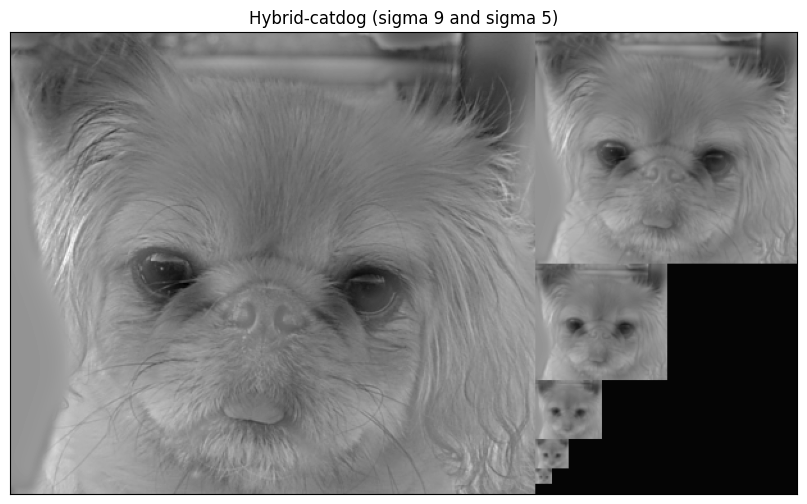

In [ ]:
displayHybridPyramid('cat.bmp','dog.bmp',9,5)

En el caso del submarino y el pez, está claro que el submarino es más suave, además de que tiene el mismo color, mientras que el pez tiene escamas y bordes. Veamos una primera prueba con sigmas por defecto.

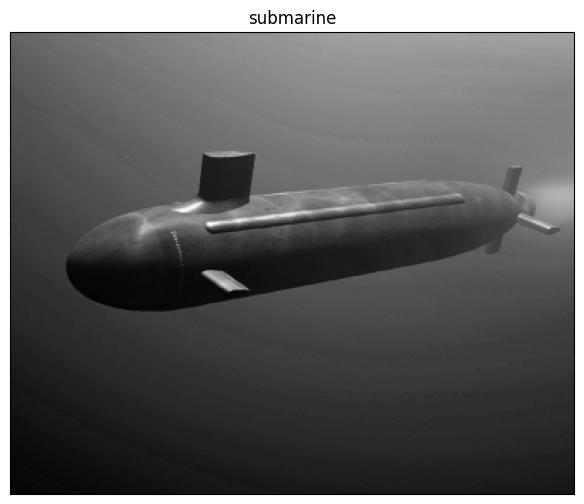

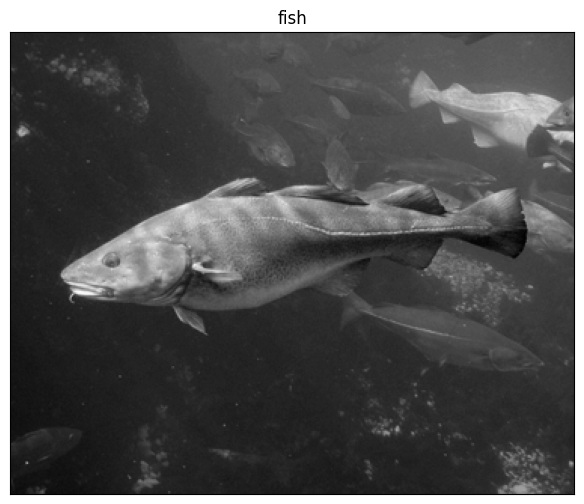

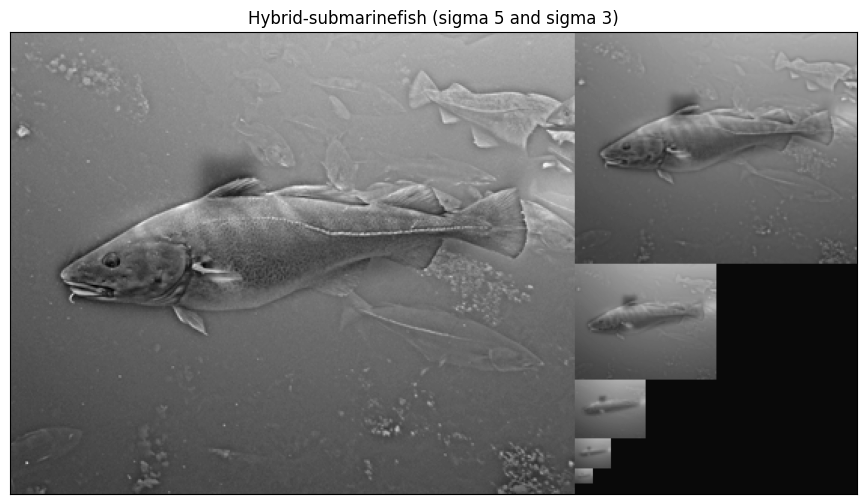

In [ ]:
displayHybridPyramid('submarine.bmp','fish.bmp',5,3, original=True)

Realmente este intento ya está bastante bien. A primera vista en la imagen nivel 0 se ve un pez, aunque sin fijarnos mucho vemos que sobresale bastante la torre de mando del submarino. Si nos fijamos un poco más vemos que el submarino se ha convertido en una sombra negra que pasa desapercibida, salvo la torre de mando. Ya en los niveles 4 y 5 no cabe duda en que lo que vemos es un submarino.
Simplemente por intentar, vamos a ver si se puede suavizar más el submarino para que la torre de mando no destaque tanto. No vamos a insistir mucho en el pez, ya que en general está bastante bien, y si intentamos que se realze más empezará a afectar las imágenes de los niveles 4 y 5, que están muy bien.

In [ ]:
for i1 in [5, 7, 9]:
  for i2 in [2, 3, 4]:
    displayHybridPyramid('submarine.bmp','fish.bmp',i1,i2)

Output hidden; open in https://colab.research.google.com to view.

En general, se observa que el submarino se ve cada vez más borroso, aunque la torre de mando se atenúa bastante. Aquí hay que elegir lo que preferimos más, una imagen más borrosa desde lejos, o una imagen con una mancha negra desde cerca. Yo opto por la imagen que obtuvimos en el primer intento. Realmente no se puede hacer nada con la torre, ya que es algo que el pez no tiene (aunque si tiene una aleta superior). Si pudieramos modificar el color del submarino, nos ayudaría mucho hacerlo de un color más claro. Así al hacerse el suavizado no se notará tanto la torre de mando, pero en nuestro caso este es el mejor resultado.

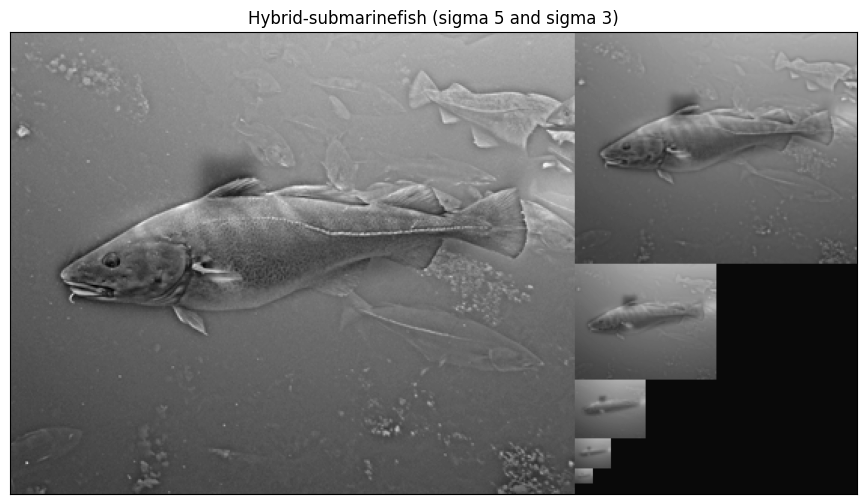

In [ ]:
displayHybridPyramid('submarine.bmp','fish.bmp',5,3)

En la pareja Marilyn-Einstein observamos que Marilyn es más suave, no solo porque es mujer y más joven que Einstein, lo cual se traduce en una piel más lisa y con menos desperfectos y por lo tanto, menos frecuencias altas, sino porque tiene un fondo blanco y pelo recogido. Einstein tiene un fondo negro y pelo blanco desordenado, lo cual crea muchas frecuencias altas. Marilyn tiene pelo que pasa de blanco a negro suavemente, y las zonas negras y blancas están bastante agrupadas. Luego Marilyn será la imagen con frecuencias bajas y Einstein con altas. Veamos una primera prueba.

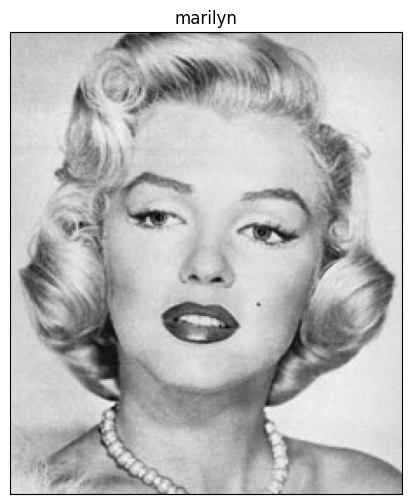

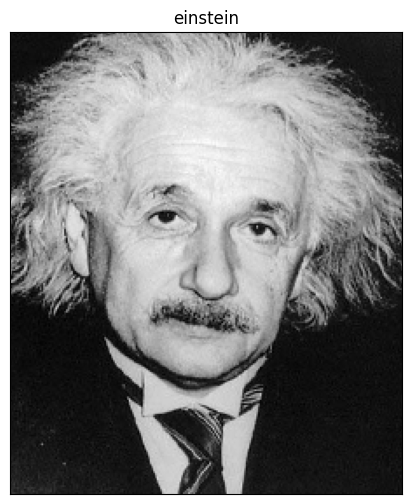

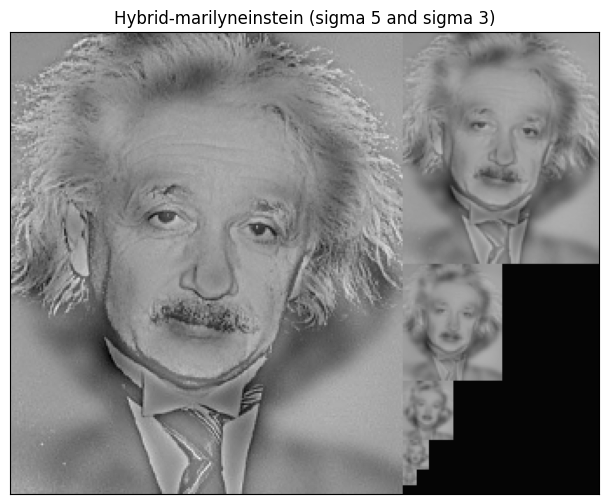

In [ ]:
displayHybridPyramid('marilyn.bmp','einstein.bmp',5,3, original=True)

Parece que el resultado es relativamente bueno. Desafortunadamente, el pelo de Marilyn se extiende por debajo de su cabeza, en una zona donde Einstein no tiene nada, lo cual crea una sombra alrededor de Einstein algo antinatural. Aquí pasa lo mismo que con el submarino, si suavizamos más a Marilyn se verán más borrosas las imágenes de nivel 4 y 5, y si realzamos más a Einstein empezará a afectar las imágenes de niveles más altos y no contruibuirá nada a la desaparición de la sombra ya que por debajo de su cabeza solo hay fondo negro, es decir frecuencias muy bajas. Pero por probar, vamos a experimentar con otros valores de sigma.

In [ ]:
for i1 in [5, 7, 9]:
  for i2 in [2, 3, 4]:
    displayHybridPyramid('marilyn.bmp','einstein.bmp',i1,i2)

Output hidden; open in https://colab.research.google.com to view.

En efecto, vemos que el resultado obtenido concuerda con lo que había dicho antes. Nos quedamos con el primer intento.

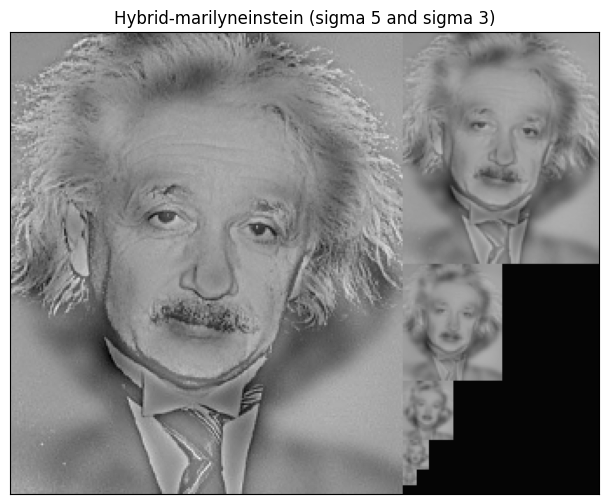

In [ ]:
displayHybridPyramid('marilyn.bmp','einstein.bmp',5,3)

# **Ejercicio 4: Pyramid Blending** (1 punto)

<font color=blue>En este ejercicio se debe crear la imagen fusionada de la manzana (`apple.jpg`; parte superior de la imagen fusionada final) y la naranja (`orange.jpg`; parte inferior de la imagen fusionada final) empleando la técnica de $\textit{Pyramid Blending}$. Para este ejercicio, si se desea, sí se pueden emplear las funciones de OpenCV `pyrDown` y `pyrUp`.

<font color=blue>Se debe:
1. explicar en detalle el proceso seguido a la hora de crear la nueva imagen (mezcla de ambas);
2. comparar el resultado con la combinación de las imágenes sin emplear _blending_, es decir, juntando directamente los píxeles de la mitad superior de una imagen con la mitad inferior de la otra;
3. mostrar los estados intermedios del procesado. Es decir, las pirámides Gaussianas calculadas para cada imagen (5 niveles cada una), las pirámides Laplacianas correspondientes, y los distintos niveles en que se va mezclando la imagen de salida (es decir, la reconstrucción en el nivel 1, la reconstrucción en el nivel 2,... y así sucesivamente hasta mostrar la imagen final reconstruida/_blended_).  



La técnica Pyramid Blending consiste en lo siguiente:
1. Leer dos imagenes, una contribuye la parte superior y otra la inferior.
2. Generar las pirámides Laplacianas para cada imagen.
3. Generar la pirámide Gaussiana a partir de la región (máscara).
4. Mezclar ambas pirámides Laplacianas usando la Gaussiana de la región como máscara ponderada.
5. Reconstruir la imagen a partir de la pirámide Laplaciana resultante. La imagen reconstruida será la imagen fusionada.

La siguiente función `pyramidBlending()` hace todo esto, dadas las imágenes y la región. En la creación de pirámides usamos tamaño de kernel $7$, como valor por defecto, y 5 niveles. Además de calcular la imagen fusionada, visualizamos todos los estados intermedios: las pirámides Gaussianas y Laplacianas y la reconstrucción.

In [ ]:
def pyramidBlending(im1, im2, region):
  '''
  Esta función crea la imagen fusionada de dos imagenes para una
  región dada.
  '''
  # Creamos pirámides Laplacianas y Gaussianas (Gaussianas de imagenes solo
  # para visualizarlas)
  pyrG1 = pyramidGauss(im1, sizeMask=7, nlevel=5)
  pyrG2 = pyramidGauss(im2, sizeMask=7, nlevel=5)
  pyrL1 = pyramidLap(im1, sizeMask=7, nlevel=5)
  pyrL2 = pyramidLap(im2, sizeMask=7, nlevel=5)
  pyrG = pyramidGauss(region, sizeMask=7, nlevel=5)
  # Creamos pirámide mezclada a partir de las pirámides laplacianas y gaussianas
  pyrBlend = []
  for i in range(len(pyrL1)):
    level = pyrG[i]*pyrL1[i] + (1 - pyrG[i])*pyrL2[i]
    pyrBlend.append(level)
  # Reconstruimos
  pyrRecons = reconstructLap(pyrBlend, cv2.INTER_LINEAR)
  # Visualizamos
  displayPyramid(pyrG1, 'Gaussian Pyramid 1')
  displayPyramid(pyrG2, 'Gaussian Pyramid 2')
  displayPyramid(pyrL1, 'Laplacian Pyramid 1')
  displayPyramid(pyrL2, 'Laplacian Pyramid 2')
  displayIm(rangeDisplay01(pyrRecons[0], True),'Base Image',2)
  for i in range(1, len(pyrRecons)):
    displayIm(rangeDisplay01(pyrRecons[i], True),f'Reconstruction {len(pyrRecons)-i}',2)
  displayIm(rangeDisplay01(pyrRecons[-1], True),'Final Reconstruction',2)
  return pyrRecons[-1]

Ahora vamos a leer las imágenes y comprobar qué dimensiones tienen.

In [ ]:
# Lectura de imágenes
im1 = readIm(get_image('apple.jpg'), 1)
im2 = readIm(get_image('orange.jpg'), 1)
print(f'Apple shape: {im1.shape} \n Orange shape: {im2.shape}')

Apple shape: (239, 238, 3) 
 Orange shape: (240, 240, 3)


En efecto, vemos que tienen dimensiones distintas. Luego será necesario redimensionar una de las imágenes para poder hacer el fusionado. Además, vamos a crear la región, que tendrá las mismas dimensiones que las imágenes. La primera mitad será blanca y la segunda negra, lo cual nos permite dividir las imágenes por la mitad a la hora de fusionar usando esta máscara. Para obtener un resultado mejor, queremos que el cambio de blanco a negro en la mitad de la región sea más suave, para eso hacemos un suavizado Gaussiano con un sigma suficientemente grande para que la zona de transición de un color a otro sea bastante ancha. Veamos qué obtenemos.

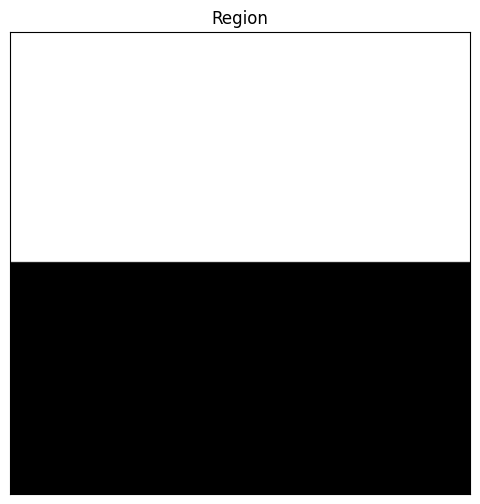

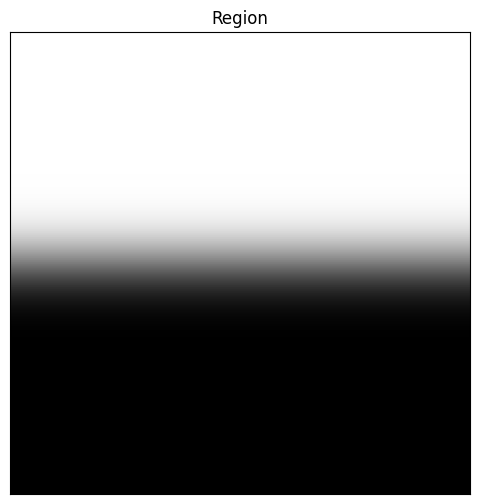

In [ ]:
im2 = cv2.resize(im2, (im1.shape[1], im1.shape[0]), cv2.INTER_LINEAR)
# Pasamos de enteros a float, en el intervalo [0,1] 0 es negro y 1 blanco
region = np.zeros(im1.shape, dtype=np.float64)
# Primera mitad blanca
region[:im1.shape[0] // 2, :] = 1.0
displayIm(region,'Region',2)
# Suavizado
region = my2DConv(region, sigma=15, orders=[0,0])
displayIm(region,'Region',2)

Vemos que la región es satisfactoria, tiene el cambio de blanco a negro suave como queríamos.
Finalmente vamos a hacer la fusión. Comparamos el resultado con la combinación de las imágenes sin blending.

In [ ]:
# Mi pirámide fusionada
pyrBlend = pyramidBlending(im1, im2, region)
# Sin blending, combino verticalmente las mitades superior e inferior
upper = im1[:im1.shape[0] // 2, :]
lower = im2[im1.shape[0] // 2:, :]
im_noblend = np.vstack((upper,lower))
# Pongo horizontalmente los resultados con y sin blending
result = np.hstack((pyrBlend,im_noblend))
displayIm(result,'Pyramid Blending vs Crisp Blending')

Output hidden; open in https://colab.research.google.com to view.

Como podemos ver, el resultado es satisfactorio. La fusión produce un resultado muy natural, donde se dispersa la zona de transición de manzana a naranja y el ojo no percibe el cambio de forma brusca, a diferencia de la combinación de las dos imágenes sin blending. Claramente el pyramid blending funciona bastante bien. Esencialmente consiste en combinar las características de las dos imágenes (con pirámides Laplacianas) usando la pirámide Gaussiana de la región como máscara ponderada, lo cual permite establecer qué imagen contribuye qué mitad de la imagen fusionada. Al obtener una pirámide Laplaciana mixta, reconstruimos una imagen que no existía a partir de esa pirámide, obteniendo la fusión.